In [51]:
!pip install ucimlrepo
!pip install tensorflow
!pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

TensorFlow version: 2.19.0


In [52]:
forest_fires = fetch_ucirepo(id=162)

X = forest_fires.data.features
y = forest_fires.data.targets

print("Информация о датасете Forest Fires:")
print(f"Размерность признаков (X): {X.shape}")
print(f"Размерность целевой переменной (y): {y.shape}")

print("\nНазвания признаков:")
print(X.columns.tolist())

print("\nНазвания целевых переменных:")
print(y.columns.tolist())

print("\nСтатистика целевой переменной 'area':")
print(y['area'].describe())

print("\nПервые 5 строк признаков:")
print(X.head())

print("\nПервые 5 строк целевой переменной:")
print(y.head())

print(f"\nПропущенные значения в X: {X.isnull().sum().sum()}")
print(f"Пропущенные значения в y: {y.isnull().sum().sum()}")

Информация о датасете Forest Fires:
Размерность признаков (X): (517, 12)
Размерность целевой переменной (y): (517, 1)

Названия признаков:
['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

Названия целевых переменных:
['area']

Статистика целевой переменной 'area':
count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

Первые 5 строк признаков:
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0

Первые 5 строк целевой переменной:
   area
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0

П

Типы данных в признаках:
X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
dtype: object

Уникальные значения в категориальных признаках:
month: ['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov']
day: ['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu']


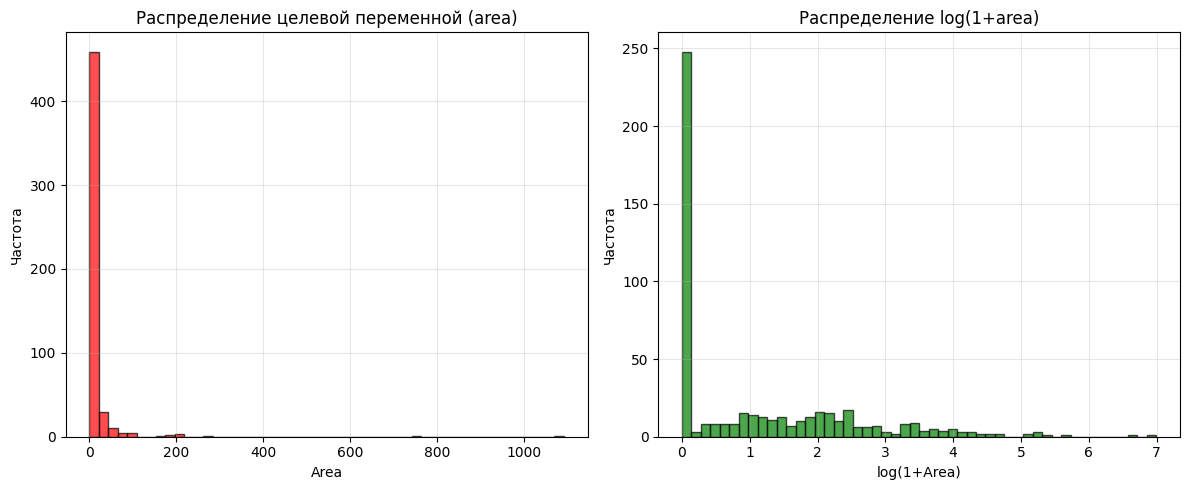


Размер train выборки: (413, 12)
Размер test выборки: (104, 12)
Количество признаков: 12


In [53]:
print("Типы данных в признаках:")
print(X.dtypes)

print("\nУникальные значения в категориальных признаках:")
print("month:", X['month'].unique())
print("day:", X['day'].unique())

from sklearn.preprocessing import LabelEncoder

X_processed = X.copy()

le_month = LabelEncoder()
le_day = LabelEncoder()

X_processed['month'] = le_month.fit_transform(X['month'])
X_processed['day'] = le_day.fit_transform(X['day'])

if X_processed.isnull().sum().sum() > 0:
    print("Заполняем пропущенные значения...")
    X_processed = X_processed.fillna(X_processed.mean())

y_target = y['area'].values
y_target_log = np.log1p(y_target)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_target, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Распределение целевой переменной (area)')
plt.xlabel('Area')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y_target_log, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Распределение log(1+area)')
plt.xlabel('log(1+Area)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_target_log, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print(f"\nРазмер train выборки: {X_train_scaled.shape}")
print(f"Размер test выборки: {X_test_scaled.shape}")
print(f"Количество признаков: {X_train_scaled.shape[1]}")

In [54]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.01, momentum=0.9):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.W = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

        self.W_inc = np.zeros((n_visible, n_hidden))
        self.v_bias_inc = np.zeros(n_visible)
        self.h_bias_inc = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))

    def sample_hidden(self, visible):
        activation = np.dot(visible, self.W) + self.h_bias
        p_hidden = self.sigmoid(activation)
        return p_hidden, np.random.binomial(1, p_hidden)

    def sample_visible(self, hidden):
        activation = np.dot(hidden, self.W.T) + self.v_bias
        p_visible = self.sigmoid(activation)
        return p_visible, np.random.binomial(1, p_visible)

    def contrastive_divergence(self, input_data, k=1):
        pos_hidden_probs, pos_hidden_states = self.sample_hidden(input_data)
        hidden_states = pos_hidden_states
        for _ in range(k):
            neg_visible_probs, neg_visible_states = self.sample_visible(hidden_states)
            neg_hidden_probs, neg_hidden_states = self.sample_hidden(neg_visible_states)
            hidden_states = neg_hidden_states

        positive_associations = np.dot(input_data.T, pos_hidden_probs)
        negative_associations = np.dot(neg_visible_states.T, neg_hidden_probs)

        self.W_inc = self.momentum * self.W_inc + \
                    self.learning_rate * ((positive_associations - negative_associations) / len(input_data))
        self.v_bias_inc = self.momentum * self.v_bias_inc + \
                         self.learning_rate * np.mean(input_data - neg_visible_states, axis=0)
        self.h_bias_inc = self.momentum * self.h_bias_inc + \
                         self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0)

        self.W += self.W_inc
        self.v_bias += self.v_bias_inc
        self.h_bias += self.h_bias_inc

        reconstruction_error = np.mean((input_data - neg_visible_probs) ** 2)
        return reconstruction_error

    def transform(self, data):
        hidden_probs, _ = self.sample_hidden(data)
        return hidden_probs

    def get_weights(self):
        return [self.W, self.h_bias]

RBM ДЛЯ ПРЕДОБУЧЕНИЯ


In [55]:

X_min = X_train_scaled.min()
X_max = X_train_scaled.max()
X_train_rbm = (X_train_scaled - X_min) / (X_max - X_min)
X_test_rbm = (X_test_scaled - X_min) / (X_max - X_min)

input_dim = X_train_scaled.shape[1]
pretrained_weights_rbm = []

print(f"Размерность входных данных: {input_dim}")

print("\n1. Обучение первого RBM слоя (128 нейронов):")
rbm1 = RBM(n_visible=input_dim, n_hidden=128, learning_rate=0.01, momentum=0.9)

rbm1_errors = []
for epoch in range(100):
    error = rbm1.contrastive_divergence(X_train_rbm, k=1)
    rbm1_errors.append(error)
    if epoch % 20 == 0:
        print(f"   Epoch {epoch}, Reconstruction Error: {error:.4f}")

pretrained_weights_rbm.append(rbm1.get_weights())
hidden1_output = rbm1.transform(X_train_rbm)

print("\n2. Обучение второго RBM слоя (64 нейрона):")
rbm2 = RBM(n_visible=128, n_hidden=64, learning_rate=0.01, momentum=0.9)

rbm2_errors = []
for epoch in range(100):
    error = rbm2.contrastive_divergence(hidden1_output, k=1)
    rbm2_errors.append(error)
    if epoch % 20 == 0:
        print(f"   Epoch {epoch}, Reconstruction Error: {error:.4f}")

pretrained_weights_rbm.append(rbm2.get_weights())
hidden2_output = rbm2.transform(hidden1_output)

print("\n3. Обучение третьего RBM слоя (32 нейрона):")
rbm3 = RBM(n_visible=64, n_hidden=32, learning_rate=0.01, momentum=0.9)

rbm3_errors = []
for epoch in range(100):
    error = rbm3.contrastive_divergence(hidden2_output, k=1)
    rbm3_errors.append(error)
    if epoch % 20 == 0:
        print(f"   Epoch {epoch}, Reconstruction Error: {error:.4f}")

pretrained_weights_rbm.append(rbm3.get_weights())

Размерность входных данных: 12

1. Обучение первого RBM слоя (128 нейронов):
   Epoch 0, Reconstruction Error: 0.0154
   Epoch 20, Reconstruction Error: 0.0023
   Epoch 40, Reconstruction Error: 0.0016
   Epoch 60, Reconstruction Error: 0.0013
   Epoch 80, Reconstruction Error: 0.0013

2. Обучение второго RBM слоя (64 нейрона):
   Epoch 0, Reconstruction Error: 0.0003
   Epoch 20, Reconstruction Error: 0.0002
   Epoch 40, Reconstruction Error: 0.0002
   Epoch 60, Reconstruction Error: 0.0002
   Epoch 80, Reconstruction Error: 0.0001

3. Обучение третьего RBM слоя (32 нейрона):
   Epoch 0, Reconstruction Error: 0.0006
   Epoch 20, Reconstruction Error: 0.0002
   Epoch 40, Reconstruction Error: 0.0001
   Epoch 60, Reconstruction Error: 0.0001
   Epoch 80, Reconstruction Error: 0.0001


In [56]:
pretrained_model_rbm = models.Sequential()
pretrained_model_rbm.add(layers.Dense(128, activation='sigmoid', input_shape=(input_dim,), name='pretrained_layer1'))
pretrained_model_rbm.add(layers.Dropout(0.3))
pretrained_model_rbm.add(layers.Dense(64, activation='sigmoid', name='pretrained_layer2'))
pretrained_model_rbm.add(layers.Dropout(0.3))
pretrained_model_rbm.add(layers.Dense(32, activation='sigmoid', name='pretrained_layer3'))
pretrained_model_rbm.add(layers.Dropout(0.2))
pretrained_model_rbm.add(layers.Dense(1, activation='linear', name='output_layer'))

pretrained_model_rbm.layers[0].set_weights([pretrained_weights_rbm[0][0], pretrained_weights_rbm[0][1]])
pretrained_model_rbm.layers[2].set_weights([pretrained_weights_rbm[1][0], pretrained_weights_rbm[1][1]])
pretrained_model_rbm.layers[4].set_weights([pretrained_weights_rbm[2][0], pretrained_weights_rbm[2][1]])

pretrained_model_rbm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

pretrained_model_rbm.summary()

history_pretrained_rbm = pretrained_model_rbm.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_layer1 (Dense)       │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer2 (Dense)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer3 (Dense)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.1370 - mae: 1.2156 - val_loss: 1.5342 - val_mae: 0.9720 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3629 - mae: 1.2089 - val_loss: 1.5960 - val_mae: 1.0829 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0509 - mae: 1.2254 - val_loss: 1.5452 - val_mae: 1.0568 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1675 - mae: 1.2063 - val_loss: 1.5064 - val_mae: 1.0330 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0425 - mae: 1.1882 - val_loss: 1.4808 - val_mae: 1.0107 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8204 - mae: 1.1273 - val_loss: 1.4890 - val_mae: 1.0197 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1541 - mae: 1.2113 - val_loss: 1.4995 - val_mae: 1.0285 - learning_rate: 0.0010
Epoch 

In [57]:
def create_base_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')
    ])
    return model

base_model = create_base_model(input_dim)
base_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

base_model.summary()
history_base = base_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.0436 - mae: 1.1656 - val_loss: 1.6885 - val_mae: 0.9986 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4091 - mae: 1.1622 - val_loss: 1.5820 - val_mae: 1.0333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1474 - mae: 1.1886 - val_loss: 1.5645 - val_mae: 1.0340 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0572 - mae: 1.1381 - val_loss: 1.5306 - val_mae: 1.0190 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0087 - mae: 1.1429 - val_loss: 1.5204 - val_mae: 1.0013 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2325 - mae: 1.2130 - val_loss: 1.5313 - val_mae: 0.9899 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9622 - mae: 1.0635 - val_loss: 1.5343 - val_mae: 0.9992 - learning_rate: 0.0010
Epoch 8/10

In [58]:
def evaluate_regression_model(model, X_test, y_test_log, model_name):
    y_pred_log = model.predict(X_test, verbose=0).flatten()
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return mse, mae, rmse, r2, y_pred




mse_base, mae_base, rmse_base, r2_base, y_pred_base = evaluate_regression_model(
    base_model, X_test_scaled, y_test, "БАЗОВАЯ МОДЕЛЬ")

mse_rbm, mae_rbm, rmse_rbm, r2_rbm, y_pred_rbm = evaluate_regression_model(
    pretrained_model_rbm, X_test_scaled, y_test, "МОДЕЛЬ С RBM")

improvement_mse = ((mse_base - mse_rbm) / mse_base) * 100
improvement_mae = ((mae_base - mae_rbm) / mae_base) * 100
improvement_rmse = ((rmse_base - rmse_rbm) / rmse_base) * 100
improvement_r2 = (r2_rbm - r2_base) * 100

print(f"\nУЛУЧШЕНИЕ RBM МОДЕЛИ ОТНОСИТЕЛЬНО БАЗОВОЙ:")
print(f"MSE: {improvement_mse:+.2f}%")
print(f"MAE: {improvement_mae:+.2f}%")
print(f"RMSE: {improvement_rmse:+.2f}%")
print(f"R²: {improvement_r2:+.2f}%")


БАЗОВАЯ МОДЕЛЬ:
MSE: 12083.3999
MAE: 19.7505
RMSE: 109.9245
R² Score: -0.0251

МОДЕЛЬ С RBM:
MSE: 12104.6972
MAE: 19.7866
RMSE: 110.0213
R² Score: -0.0269

УЛУЧШЕНИЕ RBM МОДЕЛИ ОТНОСИТЕЛЬНО БАЗОВОЙ:
MSE: -0.18%
MAE: -0.18%
RMSE: -0.09%
R²: -0.18%


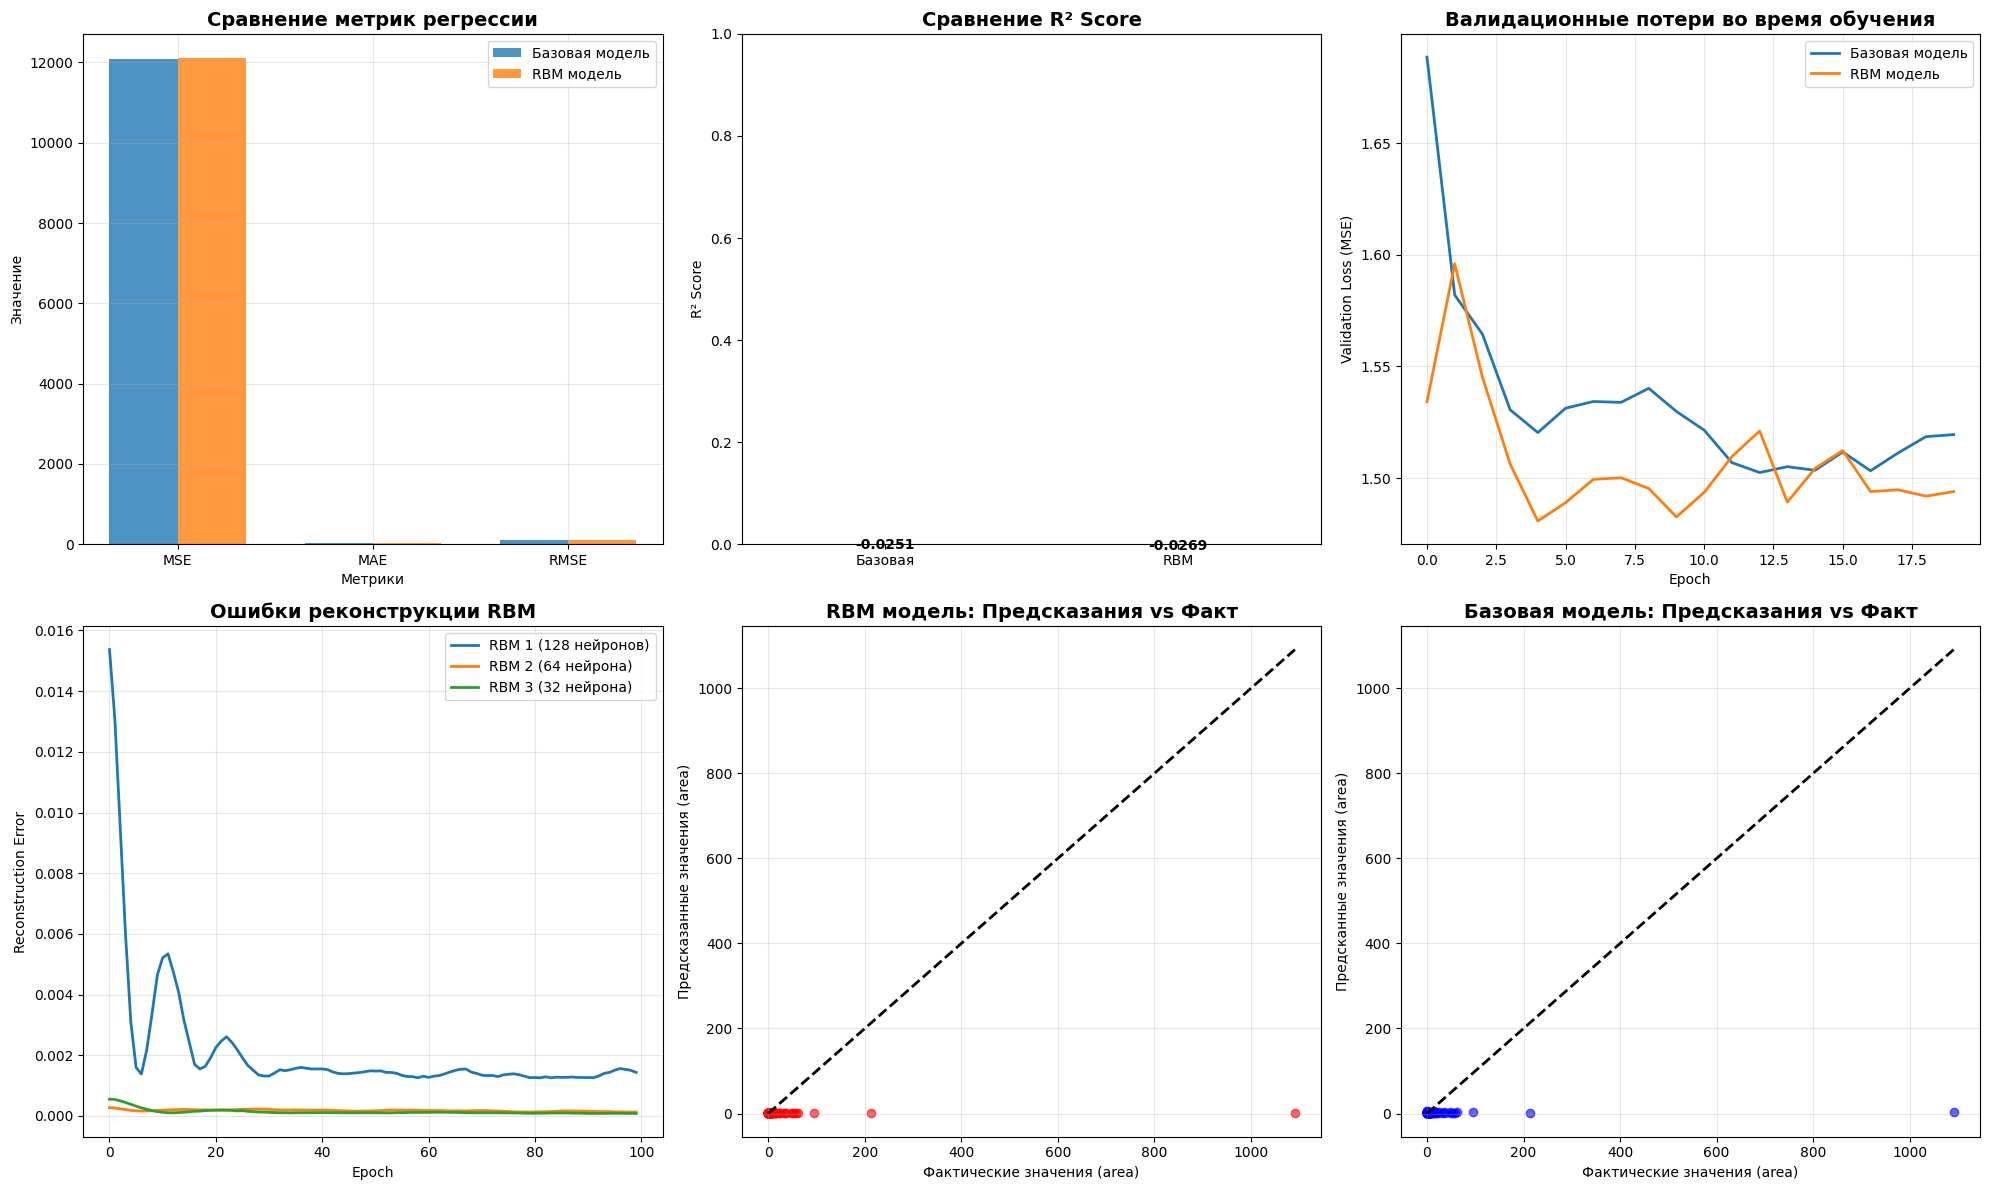

In [59]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
metrics = ['MSE', 'MAE', 'RMSE']
base_scores = [mse_base, mae_base, rmse_base]
rbm_scores = [mse_rbm, mae_rbm, rmse_rbm]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, base_scores, width, label='Базовая модель', alpha=0.8)
plt.bar(x + width/2, rbm_scores, width, label='RBM модель', alpha=0.8)

plt.title('Сравнение метрик регрессии', fontsize=14, fontweight='bold')
plt.xlabel('Метрики')
plt.ylabel('Значение')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
models_names = ['Базовая', 'RBM']
r2_scores = [r2_base, r2_rbm]
colors = ['skyblue', 'lightcoral']

bars = plt.bar(models_names, r2_scores, color=colors, alpha=0.8)
plt.title('Сравнение R² Score', fontsize=14, fontweight='bold')
plt.ylabel('R² Score')
plt.ylim(0, 1)
for bar, r2 in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{r2:.4f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(2, 3, 3)
min_epochs = min(len(history_base.history['val_loss']),
                 len(history_pretrained_rbm.history['val_loss']))
epochs_range = range(min_epochs)

plt.plot(epochs_range, history_base.history['val_loss'][:min_epochs],
         label='Базовая модель', linewidth=2)
plt.plot(epochs_range, history_pretrained_rbm.history['val_loss'][:min_epochs],
         label='RBM модель', linewidth=2)
plt.title('Валидационные потери во время обучения', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
plt.plot(rbm1_errors, label='RBM 1 (128 нейронов)', linewidth=2)
plt.plot(rbm2_errors, label='RBM 2 (64 нейрона)', linewidth=2)
plt.plot(rbm3_errors, label='RBM 3 (32 нейрона)', linewidth=2)
plt.title('Ошибки реконструкции RBM', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
y_true = np.expm1(y_test)
plt.scatter(y_true, y_pred_rbm, alpha=0.6, color='red')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.title('RBM модель: Предсказания vs Факт', fontsize=14, fontweight='bold')
plt.xlabel('Фактические значения (area)')
plt.ylabel('Предсказанные значения (area)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.scatter(y_true, y_pred_base, alpha=0.6, color='blue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.title('Базовая модель: Предсказания vs Факт', fontsize=14, fontweight='bold')
plt.xlabel('Фактические значения (area)')
plt.ylabel('Предсканные значения (area)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

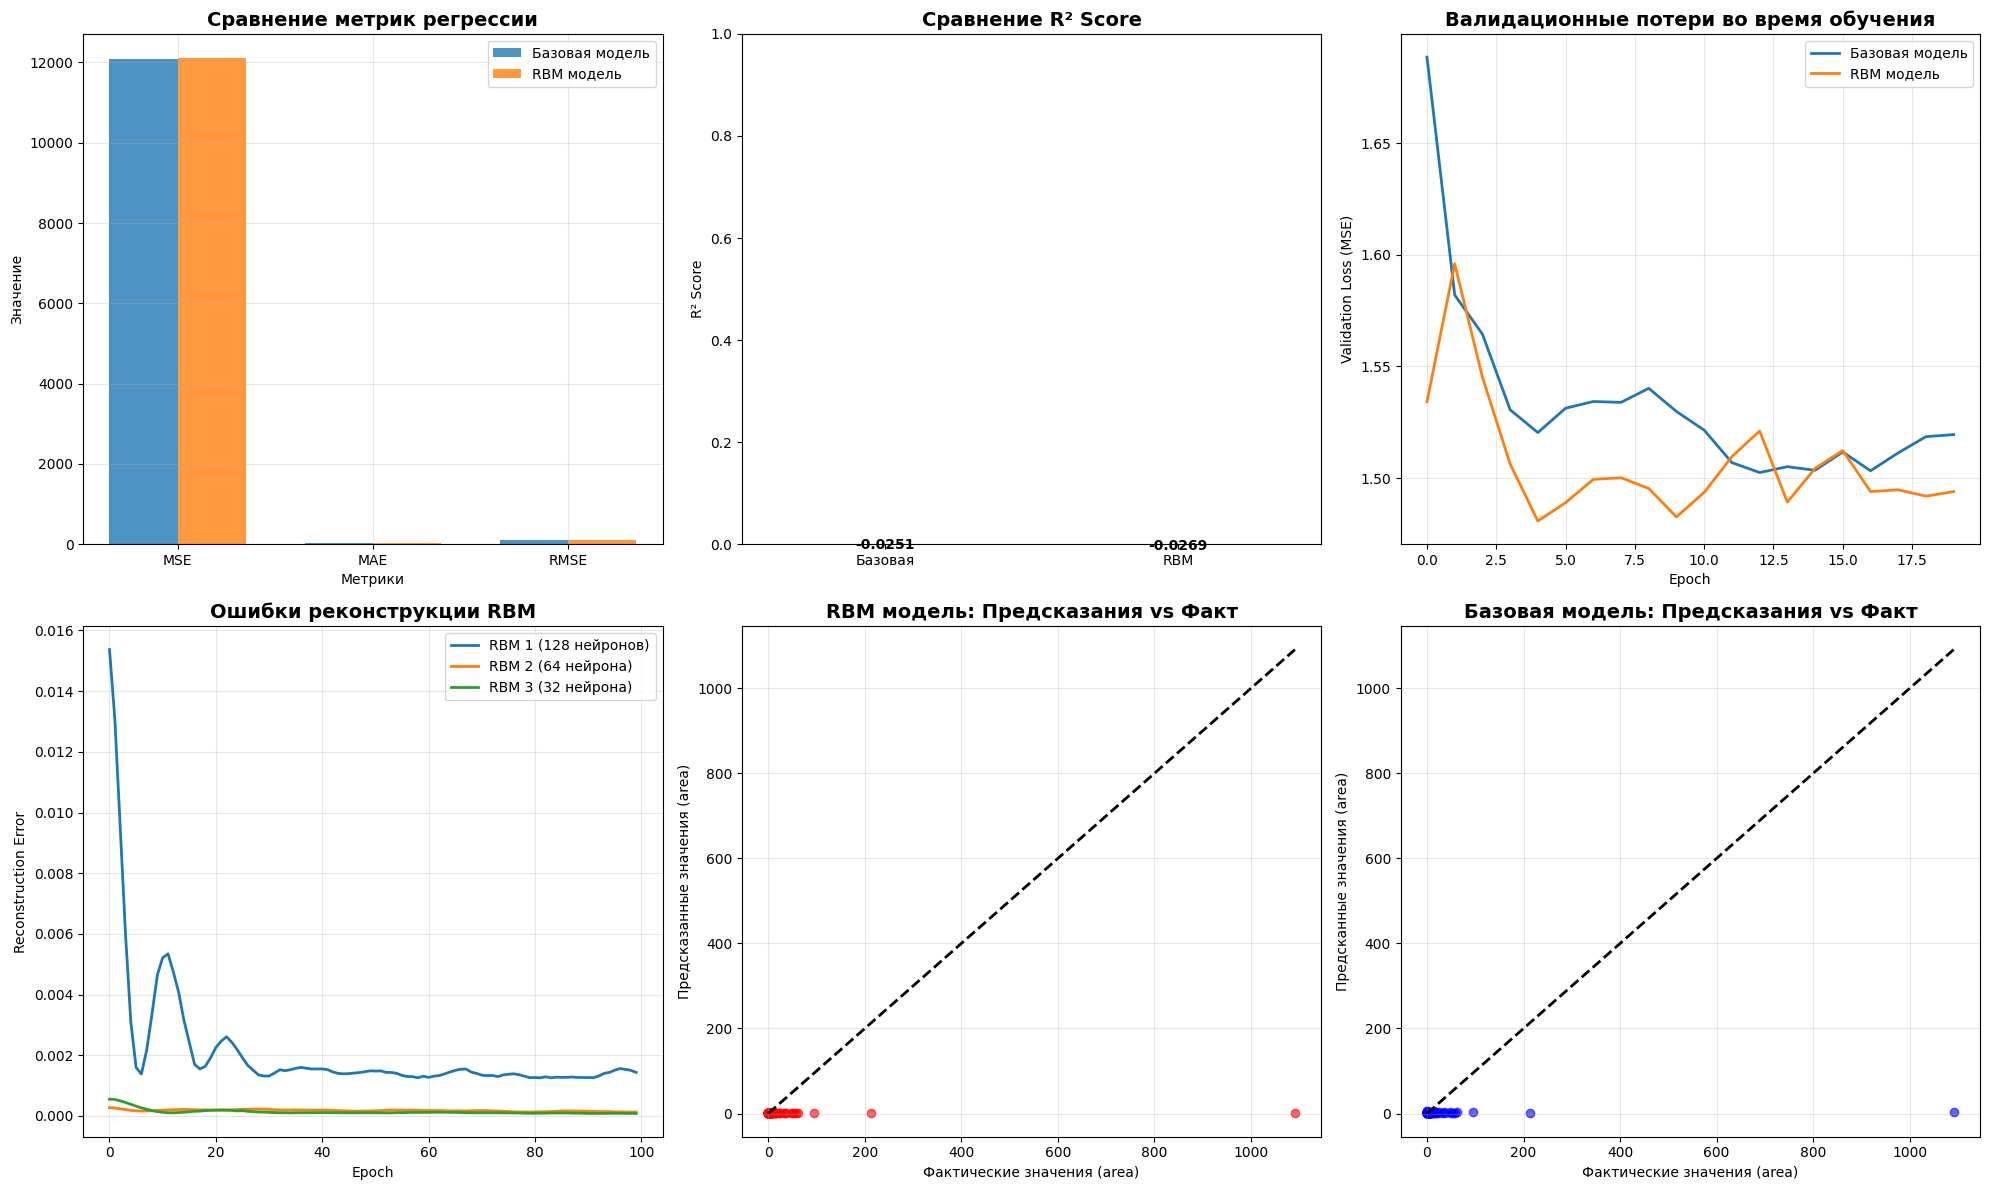